In [50]:
import re
import seaborn as sns
import threading
from tqdm import tqdm
import torch

from dataclasses import dataclass, fields, asdict
from model.model import PageAccModel

In [51]:
@dataclass
class Page:
    buffer: int
    is_local_temp: int
    fork_num: int
    block_num: int
    mode: int
    relam: int
    relfilenode: int
    relhasindex: int
    relpersistence: int
    relkind: int
    relnatts: int
    relfrozenxid: int
    relminmxid: int
    hit: int

In [52]:
with open("train_data/acc_logfile2", "r") as file:
    data = file.read()

pattern = r"buffer={(\d+)} is_local_temp={(\w+)} fork_num={(\w+)} block_num={(\d+)} mode={(\w+)} strategy={} relam={(\d+)} relfilenode={(\d+)} relhasindex={(\w+)} relpersistence={(\w+)} relkind={(\w+)} relnatts={(\d+)} relfrozenxid={(\d+)} relminmxid={(\d+)} hit={(\w+)}"
matches = re.findall(pattern, data)

pages = []

for match in matches:
    buffer = int(match[0])
    is_local_temp = 1 if match[1] == "true" else 0
    fork_num = ["MAIN_FORKNUM", "FSM_FORKNUM", "VISIBILITYMAP_FORKNUM", "INIT_FORKNUM"].index(match[2])
    block_num = int(match[3])
    mode = ["RBM_NORMAL", "RBM_ZERO_AND_LOCK", "RBM_ZERO_AND_CLEANUP_LOCK", "RBM_ZERO_ON_ERROR", "RBM_NORMAL_NO_LOG"].index(match[4])
    relam = int(match[5])
    relfilenode = int(match[6])
    relhasindex = 1 if match[7] == "true" else 0
    relpersistence = ["p", "u", "t"].index(match[8])
    relkind = ["r", "i", "S", "t", "v", "m", "c", "f", "p", "I"].index(match[9])
    relnatts = int(match[10])
    relfrozenxid = int(match[11])
    relminmxid = int(match[12])
    hit = 1 if match[13] == "true" else 0

    page = Page(
        buffer,
        is_local_temp, 
        fork_num,
        block_num,
        mode,
        relam,
        relfilenode,
        relhasindex,
        relpersistence,
        relkind,
        relnatts,
        relfrozenxid,
        relminmxid,
        hit,
    )
    pages.append(page)

In [53]:
with open("train_data/acc_logfile2_pages", "w") as f:
    for page in pages:
        f.write(f"{page.buffer}\n")


In [54]:
print(len(pages))

1024067


In [55]:
# evict page with last access
def find_optimal_victim(page_access_ar, buf, current_index):
    #MAX_RATE = 10000
    evict_ind = 0
    evict_rate = 0

    # mutex = threading.Lock()

    def check_items_rate(start, stop):
        nonlocal evict_ind
        nonlocal evict_rate

        for i in range(start, stop):
            rate = 0
            for page in page_access_ar[current_index:]:
                rate += 1
                if page == buf[i]:
                    break
            
            # with mutex:
            if rate > evict_rate:
                evict_rate = rate
                evict_ind = i
    
    check_items_rate(0, len(buf))
    # threads = []
    # threads_count = 16
    # step = len(buf) // threads_count
    # for i in range(threads_count):
    #     start = i * step
    #     stop = len(buf) if i == threads_count - 1 else (i + 1) * step
    #     check_items_rate(start, stop)
    #     # thread = threading.Thread(target=lambda: check_items_rate(start, stop))
    #     # threads.append(thread)
    #     # thread.start()

    # for thread in threads:
    #     thread.join()
    
    return evict_ind
 
def find_optimal_hit_rate(page_access_ar, buf_size):
    buf = []
    hit = 0
    # for i, page in tqdm(enumerate(page_access_ar)):
    for i in tqdm(range(len(page_access_ar))):
        page = page_access_ar[i]
        if page in buf:
            hit += 1
            continue

        if len(buf) < buf_size:
            buf.append(page)
        else:
            evict_ind = find_optimal_victim(page_access_ar, buf, i)
            buf[evict_ind] = page
    
    return hit / len(page_access_ar)

In [61]:
optimal_results = []
with open("train_data/acc_logfile2_victims", "r") as f:
    for line in f:
        optimal_results.append(int(line))

In [68]:
TRAIN_SIZE = len(pages)
BATCH_SIZE = 1024
BUFFER_SIZE = 32

In [58]:
sum([page.hit for page in pages[:TRAIN_SIZE]]) / TRAIN_SIZE

0.6318912727389907

In [63]:
# find_optimal_hit_rate([page.buffer for page in pages[:TRAIN_SIZE]], BUFFER_SIZE)
sum([1 if victim < BUFFER_SIZE else 0 for victim in optimal_results[:TRAIN_SIZE]]) / TRAIN_SIZE

0.3155281832145748

<Axes: ylabel='Count'>

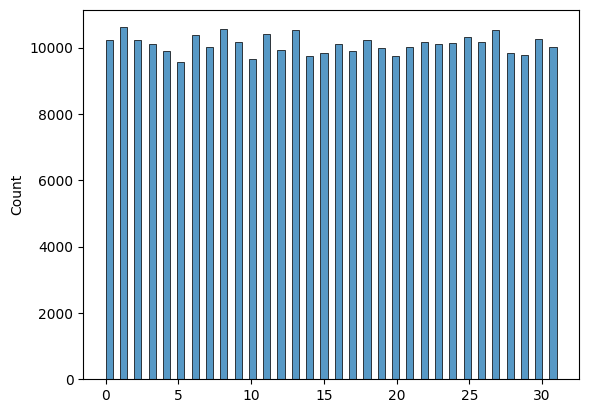

In [64]:
sns.histplot([victim for victim in optimal_results[:TRAIN_SIZE] if victim < BUFFER_SIZE])

In [70]:
def get_model_optimal_res(pages, buffer, current_index):
    res = [0] * (len(buffer) + 1)
    already_in_buf = any(buf.buffer == pages[current_index].buffer for buf in buffer)
    if already_in_buf:
        res[-1] = 1
        return res, -1
    
    empty_pages = [index for index, value in enumerate(buffer) if value.buffer == -1]
    if len(empty_pages) > 0:
        for i in empty_pages:
            res[i] = 1 / len(empty_pages)
        
        return res, empty_pages[0]
    
    #victim = find_optimal_victim(pages, [page.buffer for page in buffer], current_index)
    victim = optimal_results[current_index]
    res[victim] = 1

    return res, victim

In [24]:
def get_train_data(pages, buffer, batch_start, batch_end):
    pages_acc = torch.Tensor([list(asdict(page).values()) for page in pages[batch_start:batch_end]])

    buffers = []
    optimal_predictions = []

    for i in range(batch_start, batch_end):
        buffers.append([value for obj in buffer for value in asdict(obj).values()])

        res, victim = get_model_orangeptimal_res(pages, buffer, i)
        optimal_predictions.append(res)

        if victim >= 0:
            buffer[victim] = pages[i]
    
    return pages_acc, torch.Tensor(buffers), torch.Tensor(optimal_predictions), buffer


In [71]:
model = PageAccModel(len(fields(Page)), 32, BUFFER_SIZE)

In [69]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

buffer = [Page(-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1)] * BUFFER_SIZE
h, c = None, None

model.train()
pbar = tqdm(range(0, TRAIN_SIZE, BATCH_SIZE))
for i in pbar:
    batch_start = i
    batch_end = i + BATCH_SIZE if i + BUFFER_SIZE < TRAIN_SIZE else TRAIN_SIZE
    pages_acc, buffers, optimal_predictions, buffer = get_train_data(pages, buffer, batch_start, batch_end)

    optimizer.zero_grad()

    out, h, c = model.forward(pages_acc, buffers, h, c)
    # print(out)

    loss_value = loss(out, optimal_predictions)

    loss_value.backward()
    optimizer.step()

    h = h.detach()
    c = c.detach()
    pbar.set_postfix_str(f"loss={loss_value}")

  0%|          | 0/1001 [00:00<?, ?it/s]

1
0
0
1
31
31
24
0
25
23
22
22
24
24
24
24
23
22
23
25
0
31
15
5
14
31
31
31
31
31
31
31
4
27
26
27
27
13
12
12
11
10
9
9
8
17
18
16
25
7
6
1
3
19
16
0
2
20
29
28
23
28
24
22


  0%|          | 1/1001 [00:00<09:32,  1.75it/s, loss=3.530993938446045]

24
28
21
29
23
23
6
1
22
2
25
21
20
29
16
10
10
0
23
18
5
21
2
24
16
1
22
31
19
3
24
7
31
25
30
30
28
31
31
31
19
30
30
21
18
18
10
29
20
25
25
5
11
14
8
15
4
22
22
8
11
11
11
11
11
17
13
13
13
13
26
28
5
25
25
25
25
25
25
25
25
25
0
23
23
25
25
17
11
11
11
11
11
21
19
19
19
21
17
8
22
20
21
8
17
21
8
21
17
17
17
17
17
21
17
21
25
25
22
2
25
25
28
2
22
2
14
20
15
13
9
14
20
14
14
20
1
10
18
15
10
29
29
10
15
15
15
15
15
10


  0%|          | 2/1001 [00:01<08:42,  1.91it/s, loss=3.540365219116211]

19
8
19
19
10
10
8
23
29
29
29
18
2
12
16
27
6
14
4
1
20
29
17
30
23
23
30
30
30
23
23
20
7
7
7
21
4
1
17
26
29
6
21
7
16
12
2
27
18
22
6
14
29
5
5
5
5
5
5
5
5
5
5
5
22
22
22
22
22
22
22
22
22
22
22
14
14
14
26
26
26
26
7
15
7
7
14
7
24
3
3
3
7
7
14
15
3
29
6
29
14
6
7
6
6
7
14
22
23
26
14
29
29
29
0
4
4
4
1
1
24
8
4
20
0
30
29
19
14
14
26
23
26
14
19
26
14
3
20
10
30
24
29
8
28
25
5
20
17
9
13
10
4
25
23
0
4
7
19
7
4
26
4
7
10
4
14
4
10
10
4
9
4
10
9
10
4
9
31
4
10
10
27
12
29
16
18
2
22
2
10
21
11
8
24
18


  0%|          | 3/1001 [00:01<08:43,  1.91it/s, loss=3.5394537448883057]

16
12
12
12
12
12
12
12
12
12
12
12
12
16
16
16
16
16
6
6
15
15
15
15
27
15
29
27
29
15
15
29
22
29
22
15
22
2
22
2
11
1
24
2
24
1
29
1
24
18
1
24
1
18
24
0
0
18
1
0
24
29
29
24
24
24
24
24
24
24
24
16
3
3
7
7
14
14
14
4
4
4
4
31
9
21
4
31
4
21
31
21
4
4
21
21
23
27
10
15
15
10
10
10
23
15
15
23
11
8
8
22
22
27
27
27
31
31
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
31
12
31
12
21
17
19
21
26
19
12
19
19
7
12
7
19
12
19
7
27
19
19
19
27
27
27
27
27
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
27
19
19
27
6
27
19
31
27
19
27
31
19
9
9
31
4
10
10
4
27
4
11
23
10
23
11
24
23
23
30
20
29
0
1
18
29
2
13
26
21


  0%|          | 4/1001 [00:02<08:31,  1.95it/s, loss=3.5433595180511475]

13
25
5
14
3
23
16
24
24
24
24
24
17
17
17
24
24
17
29
29
17
29
29
24
23
14
14
5
23
25
7
23
14
7
5
23
25
25
25
25
23
23
21
26
29
29
29
29
7
24
5
14
14
17
6
6
19
9
9
4
27
22
8
11
10
15
29
27
2
18
18
15
2
27
18
18
10
8
8
18
2
15
0
0
0
0
0
17
17
14
20
20
20
20
20
4
30
28
31
25
25
21
21
15
25
0
2
23
14
17
23
3
21
25
21
30
27
22
13
12
4
20
28
26
16
10
20
16
6
29
6
1
11
15
18
14
8
16
26
28
9
9
9
9
9
9
9
9
9
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
31
31
23
3
23
27
21
10
4
1
15
11
6
11
15
15
15
14
5
14
23
16
14
8
24
11
11
24
25
20
4
10
20
25
23
26
19
5
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
28
15
31
2
2
17
9
17
2
28
27
2
0
1
0
27
17
0
0
18
6
30
30
2
2
2
2
2
2
2
2
2
2
2
21
5
21
2
5
2
21
5
21
2
5
2
21
5


  0%|          | 5/1001 [00:02<08:33,  1.94it/s, loss=3.5384769439697266]

1
7
21
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
7
7
7
7
7
7
7
7
1
5
1
5
25
5
1
25
1
5
25
5
25
5
25
1
25
5
1
5
29
7
15
28
16
29
13
22
5
22
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
22
22
22
22
22
25
25
25
25
25
25
25
30
30
30
25
22
2
25
30
22
30
25
22
25
30
22
30
25
22
25
30
22
25
30
22
30
25
22
25
22
29
22
25
25
22
30
31
3
19
2
19
23
24
13
31
20
12
30
9
20
25
5
30
12
8
14
31
13
8
30
5
5
5
24
30
25
30
24
6
25
5
5
16
23
19
5
25
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
19
8
23
19
5
25
6
22
10
26
3
2
0
5
5
19
4
4
22
4
4
22
25
1
29
29
14
24
13
31
30
12
14
13
15
16
14
15
13
1
25
27


  1%|          | 6/1001 [00:03<08:32,  1.94it/s, loss=3.5414071083068848]

1
13
1
13
15
1
15
13
1
13
15
1
15
13
1
13
1
13
15
1
25
27
27
15
13
25
1
13
15
25
15
13
14
16
27
4
16
23
5
2
18
1
17
26
1
11
4
22
30
22
30
24
24
22
24
24
22
24
24
22
24
24
22
26
24
24
22
26
24
24
22


  1%|          | 7/1001 [00:03<08:33,  1.94it/s, loss=3.5472662448883057]

26
24
29
20
20
24
22
22
30
12
16
5
11
30
21
22
16
26
26
19
26
22
21
31
31
31
31
31
31
31
31
31
31
31
31
31
31
9
13
21
8
13
9
21
9
13
21
9
13
21
13
9
21
9
21
6
21
9
6
9
21
6
21
8
12
13
14
16
13
3
30
0
3
23
7
19
21
21
21
0
23
23
23
27
27
23
0
0
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
0
0
0
22
26
22
0
26
0
22
22
22
6
6
22
22
6
23
6
23
6
9
22
8
15
22
28
15
15
28
9
30
9
10
23
13
23
10
19
10
19
16
14
10
7
7
7
7
7
7
7
11
16
14
11
7
16
10
11
14
10
16
7
3
30
21
4
31
28
15
17
25
25
25
22
22
25
25
25
25
25
25
25


  1%|          | 8/1001 [00:04<08:37,  1.92it/s, loss=3.5404305458068848]

15
17
11
19
15
28
31
4
21
30
3
7
16
10
14
14
10
10
27
27
14
14
14
14
14
14
8
12
5
8
15
12
15
6
19
6
27
6
8
6
19
6
8
6
12
15
15
12
6
12
15
6
8
19
19
8
27
19
19
6
15
12
10
5
14
14
14
14
14
14
14
10
5
27
10
22
12
15
6
19
19
19
19
19
0
0
0
0
0
0
19
6
15
12
12
12
6
19
12
15
19
6
12
6
19
12
19
6
12
6
19
12
19
6
12
6
19
4
6
19
12
21
12
21
21
8
9
1
23
13
3
12
8
8
13
7
7
7
7
7
7
7
7
9
21
21
21
9
7
21
22
11
30
17
25
14
9
17
30
22
22
22
22
22
22
22
22
22
22
22
30
22
22
22
22
22
22
22
22
22
22
30
30
30
30
30
30
22
17
22
17
9
17
9
17
30
9
30
17
30
17
30
17
31
30
31
26
30
26
31
30
31
30
17
15
15
30
31
15
17
31
15
22
31
31
4
5


  1%|          | 9/1001 [00:04<08:35,  1.92it/s, loss=3.5277352333068848]

31
22
5
21
5
14
14
14
14
14
14
14
14
25
11
5
28
5
11
28
11
5
28
5
28
27
28
5
27
5
28
30
5
5
30
30
31
31
31
31
5
5
5
5
5
5
5
9
9
9
9
16
16
16
9
5
11
1
26
11
14
26
14
25
9
25
14
16
25
15
17
0
14
7
16
14
16
7
24
7
20
24
16
15
29
0
0
29
29
0
0
29
29
0
0
3
3
3
21
13
3
8
12
0
29
15
16
24
20
4
31
7
17
14
9
30
18
2
16
15
20
15
20
16
15
16
16
15
20
15
16
20
16
15
15
23
5
15
16
5
16
15
25
16


  1%|          | 10/1001 [00:05<08:23,  1.97it/s, loss=3.4125006198883057]

1
25
4
19
6
10
2
18
10
30
9
14
17
7
14
31
31
17
18
18
31
31
18
17
31
31
18
31
31
18
31
30
31
30
30
31
30
30
31
18
30
30
31
30
18
30
31
7
14
14
30
9
2
30
14
9
14
30
30
2
21
22
22
22
22
22
22
22
20
20
23
28
22
25
26
4
26
1
4
1
26
4
26
1
4
1
26
4
26
1
1
26
25
25
1
9
25
26
22
9
1
26
25
25
26
22
1
9
9
9
14
22
14
9
9
14
14
9
9
9
14
14
9
14
9
2
2
4
4
4
9
9
9
9
18
25
18
7
7
31
4
30
4
12
17
23
26
10
1
6
19
0
12
15
12
0
3
9
3
15
15
0
19
19
26
17
16
27
27
8
4
13
5
30
22
0
30
5
30
24
4
2
4
13
30
13
24
24
24
24
24
24
24
24
24
24
28
12
14
23
29
11
17
21
28
2
0
16
26
19
22
9
13
22
19
26
30
8
27
9
2
24
17
11
4
5
4
4
5
5
4
4
5
5
4
4
5
26
19
5
4
11
12
17
31
12
11
31
31
31
31
31
31
31
10
10
10
31
6
1
28
17
6
1
1
6
28
28
4
6
1
16
24
9
27
3
1
17
31
10
17
1
10
10
19
10
31
31
3
26
31
26
3
1
17
11
3
7
2
2
1
2
2
2
2
1


  1%|          | 11/1001 [00:05<08:22,  1.97it/s, loss=3.538416862487793] 

11
20
2
15
15
1
8
20
15
11
15
8
11
11
15
11
11
15
17
11
17
2
11
2
26
31
7
8
3
7
11
5
31
8
28
28
26
4
26
0
4
18
12
25
7
11
11
7
11
11
7
25
12
7
25
30
30
27
9
27
1
25
7
7
1
1
25
26
1
25
20
7
0
4
4
4
7
7
20
26
29
20
17
29
27
27
27
27
27
27
26
1
25
0
2
25
26
26
26
26
26
1
27
25
25
1
26
2
19
3
18
16
13
11
12
22
22
22
13
16
29
19
6
21
19
13
21
16
19
22
6
21
12
13
13
31
5
11
10
12
21
6
21
21
12
9
30
24
21
14
14
21
21
22
19
19
25
26
16
6
10
10
11
11
11
31
31
31
29
31
2
7
29
11
11
7
7
31
13
5
9
12
11
12
5
21
22
3
31
27
12
10
22
27
31
10
21
8
22
17
20
31
10
8
15
15
17
6
16
26
8
8
6
6
6
17
7
4
15
8
4
20
20
20
20
22
27
20
21
21
21


  1%|          | 12/1001 [00:06<08:17,  1.99it/s, loss=3.5433602333068848]

18
4
4
3
16
16
3
3
3
21
16
1
6
26
4
26
21
18
16
18
1
29
17
15
17
17
16
8
8
7
7
13
30
25
5
19
0
12
20
16
16
26
26
26
26
26
26
24
7
21
10
31
21
7
7
24
26
26
21
21
21
21
21
21
31
21
21
21
21
21
21
21
26
10
7
10
26
10
26
10
21
21
26
4
27
4
21
21
1
21
25
30
1
1
1
14
17
17
16
25
14
29
29
29
29
29
9
24
21
26
14
2
18
24
2
2
2
18
18
18
26
0
24
18
0
0
20
12
12
20
0
14
19
5
15
11
11
12
11
20
20
0
0
0
18
14
31
24
26
21
29
15
0
0
0
11
12
30
7
8
22
27
3
10
5
17
20
19
28
2
14
18
1
16
15
4
0
15
15
0
25
0
15
15
0
25
15
0
0
15
25
0
15
20
15
20
0
25
16
0
25
29
21
21
21
16
24
21
21
16
21
16


  1%|▏         | 13/1001 [00:06<08:16,  1.99it/s, loss=3.5453133583068848]

16
21
16
6
7
26
22
7
7
20
20
7
12
11
22
6
26
21
12
23
8
3
27
17
23
10
27
10
29
10
28
7
30
10
30
14
14
18
14
14
18
4
14
31
18
31
7
4
18
7
31
18
4
7
14
31
4
18
7
31
14
31
31
14
18
4
31
18
31
18
16
16
31
16
24
31
16
18
30
24
5
4
29
25
16
25
29
12
13
8
8
30


  1%|▏         | 14/1001 [00:07<08:12,  2.00it/s, loss=3.5433597564697266]

24
10
25
16
11
22
26
6
30
9
20
17
23
21
2
26
25
26
28
9
30
28
29
12
12
28
28
28
26
26
26
26
26
25
2
2
2
2
2
2
9
21
12
12
12
21
15
15
11
14
0
23
23
2
25
23
15
31
2
7
18
2
18
2
15
7
30
30
15


  1%|▏         | 14/1001 [00:07<08:45,  1.88it/s, loss=3.5433597564697266]

13
13
10
7
0


KeyboardInterrupt: 